In [1]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import random
import os
import numpy as np

In [31]:
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
import networkx as nx

In [3]:
from PIL import Image

In [4]:
import networkx as nx
from sklearn.neighbors import NearestNeighbors

In [5]:
from IPython.display import Image as iImage
from IPython.display import display

In [6]:
import shutil

In [7]:
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [8]:
model = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)

In [9]:
def processImage(imagePath, model):
    im = load_image(imagePath)
    f = model.predict(im)[0]
    return f

In [71]:
#ONLY RUN THIS WHEN START THE PROCESS FOR A NEW TYPE OF TEXTURE
ori_folder = 'F:/stablediffusion/cat/original'
pnr_folder = 'F:/stablediffusion/PreviousNearestNeighbourResult'
img_name = 'original.jpg'
newimg_name = '16.jpg'

# Create the full path of the source and destination files
ori_path = os.path.join(ori_folder, img_name)
pnr_path = os.path.join(pnr_folder, img_name)

# Copy the image from the source folder to the destination folder
shutil.copy(ori_path, pnr_path)

# Rename the image in the destination folder
o_path = os.path.join(pnr_folder, img_name)
n_path = os.path.join(pnr_folder, newimg_name)
os.rename(o_path, n_path)

In [72]:
def process_folder(src_folder, dst_folder, prev_nn_result_folder, model):
   
    # Copy files from source to destination folder
    for filename in os.listdir(src_folder):
        src_path = os.path.join(src_folder, filename)
        dst_path = os.path.join(dst_folder, filename)
        shutil.move(src_path, dst_path)

    # Rename files in the destination folder
    for i, filename in enumerate(os.listdir(dst_folder)):
        old_path = os.path.join(dst_folder, filename)
        new_path = os.path.join(dst_folder, f"{i}.jpg")
        os.rename(old_path, new_path)

    # Move '16.jpg' from 'PreviousNearestNeighbourResult' folder to dst_folder
    src_path_16 = os.path.join(prev_nn_result_folder, '16.jpg')
    dst_path_16 = os.path.join(dst_folder, '16.jpg')
    shutil.move(src_path_16, dst_path_16)
    
    # Convert images to black and white
    bw_folder = f"{dst_folder}bw"
    ensure_folder_exists(bw_folder)
    for filename in os.listdir(dst_folder):
        input_path = os.path.join(dst_folder, filename)
        output_path = os.path.join(bw_folder, filename)
        with Image.open(input_path) as img:
            bw_img = img.convert('L')
            bw_img.save(output_path)

    # List files in the bw_folder
    bwFiles = os.listdir(bw_folder)

    # Sort bwFiles based on the integer value of the filename before the file extension
    bwFiles.sort(key=lambda x: int(x.split('.')[0]))

    # Extract features from the images in bw_folder
    features = []
    for b in bwFiles:
        path = os.path.join(bw_folder, b)
        f = processImage(path, model)
        features.append(f)

    # Compute nearest neighbors for images in features
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(features)
    distances, indices = nbrs.kneighbors(features)

    # Define and call the showNearestNeighbours function
    def showNearestNeighbours(index, indices, files, path):
        for i in indices[index]:
            f = files[i]
            print(f)
            display(iImage(filename=os.path.join(path, f)))

    showNearestNeighbours(16, indices, bwFiles, bw_folder)
    
    # Create a directed graph
    G = nx.Graph()

    for d in bwFiles:
        G.add_node(d)

    def createEdges(indices, files, distances):
        weightedEdges = []
        for i in range(len(indices)):
            index = indices[i]
            dist = distances[i][1:]

            node = files[index[0]]

            edges = []
            print(dist)
            for e in index[1:]:
                edges.append(files[e])

            for i in range(len(edges)):
                weightedEdges.append((node, edges[i], dist[i]))

        return weightedEdges

    edges = createEdges(indices, bwFiles, distances)

    G.add_weighted_edges_from(edges)

    T = nx.minimum_spanning_tree(G)
    
    fig, ax = plt.subplots(figsize = (20,20))
    
    pos = nx.spring_layout(T)  # positions for all nodes

    # draw nodes, labels and edges
    nx.draw(T, pos, with_labels=True, node_color='pink')
    
    label_pos = {node: (coord[0], coord[1] - 0.1) for node, coord in pos.items()}
    nx.draw_networkx_labels(T, label_pos)
    
    # add images on nodes
    for node in T.nodes():
        image_path = os.path.join(bw_folder, f"{node}")  # add the correct path
        image = Image.open(image_path)
        image.thumbnail((80, 80))  # shrink image to avoid it being too large
        image = np.array(image)
        imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(image), pos[node])
        ax.add_artist(imagebox)
        
    Graphfilename = "graph.png"

    # Combine the src_folder path and filename
    save_graphpath = os.path.join(src_folder, Graphfilename)

    plt.savefig(save_graphpath)
    plt.show()
    
    # Create 'Result' folders in src_folder
    r_folder = os.path.join(src_folder, 'Result')
    ensure_folder_exists(r_folder)

    # Copy the second nearest neighbor result to r_folder with its existing name, then to prev_nn_result_folder and rename it to '16.jpg'
    second_nearest_neighbor_index = indices[16][1]
    second_nearest_neighbor_filename = bwFiles[second_nearest_neighbor_index]
    src_path_second_nn = os.path.join(bw_folder, second_nearest_neighbor_filename)
    dst_path_second_nn = os.path.join(prev_nn_result_folder, '16.jpg')
    dst1_path_second_nn = os.path.join(r_folder, second_nearest_neighbor_filename)
    shutil.copy(src_path_second_nn, dst_path_second_nn)
    shutil.copy(src_path_second_nn, dst1_path_second_nn)

    # Delete '16.jpg' in bw_folder
    file_to_delete = os.path.join(bw_folder, '16.jpg')
    if os.path.exists(file_to_delete):
        os.remove(file_to_delete)
        
    # Delete '16.jpg' in dst_folder
    file_to_delete = os.path.join(dst_folder, '16.jpg')
    if os.path.exists(file_to_delete):
        os.remove(file_to_delete)

    # Create 'colour' and 'bw' folders in src_folder
    colour_folder = os.path.join(src_folder, 'colour')
    bw_folder_in_src = os.path.join(src_folder, 'bw')
    ensure_folder_exists(colour_folder)
    ensure_folder_exists(bw_folder_in_src)

    # Move 0.jpg to 15.jpg in dst_folder to 'colour' folder
    for i in range(16):
        src_path = os.path.join(dst_folder, f"{i}.jpg")
        dst_path = os.path.join(colour_folder, f"{i}.jpg")
        shutil.move(src_path, dst_path)

    # Move 0.jpg to 15.jpg in bw_folder to 'bw' folder
    for i in range(16):
        src_path = os.path.join(bw_folder, f"{i}.jpg")
        dst_path = os.path.join(bw_folder_in_src, f"{i}.jpg")
        shutil.move(src_path, dst_path)
    

1/1 [==============================] - 0s 25ms/step
16.jpg


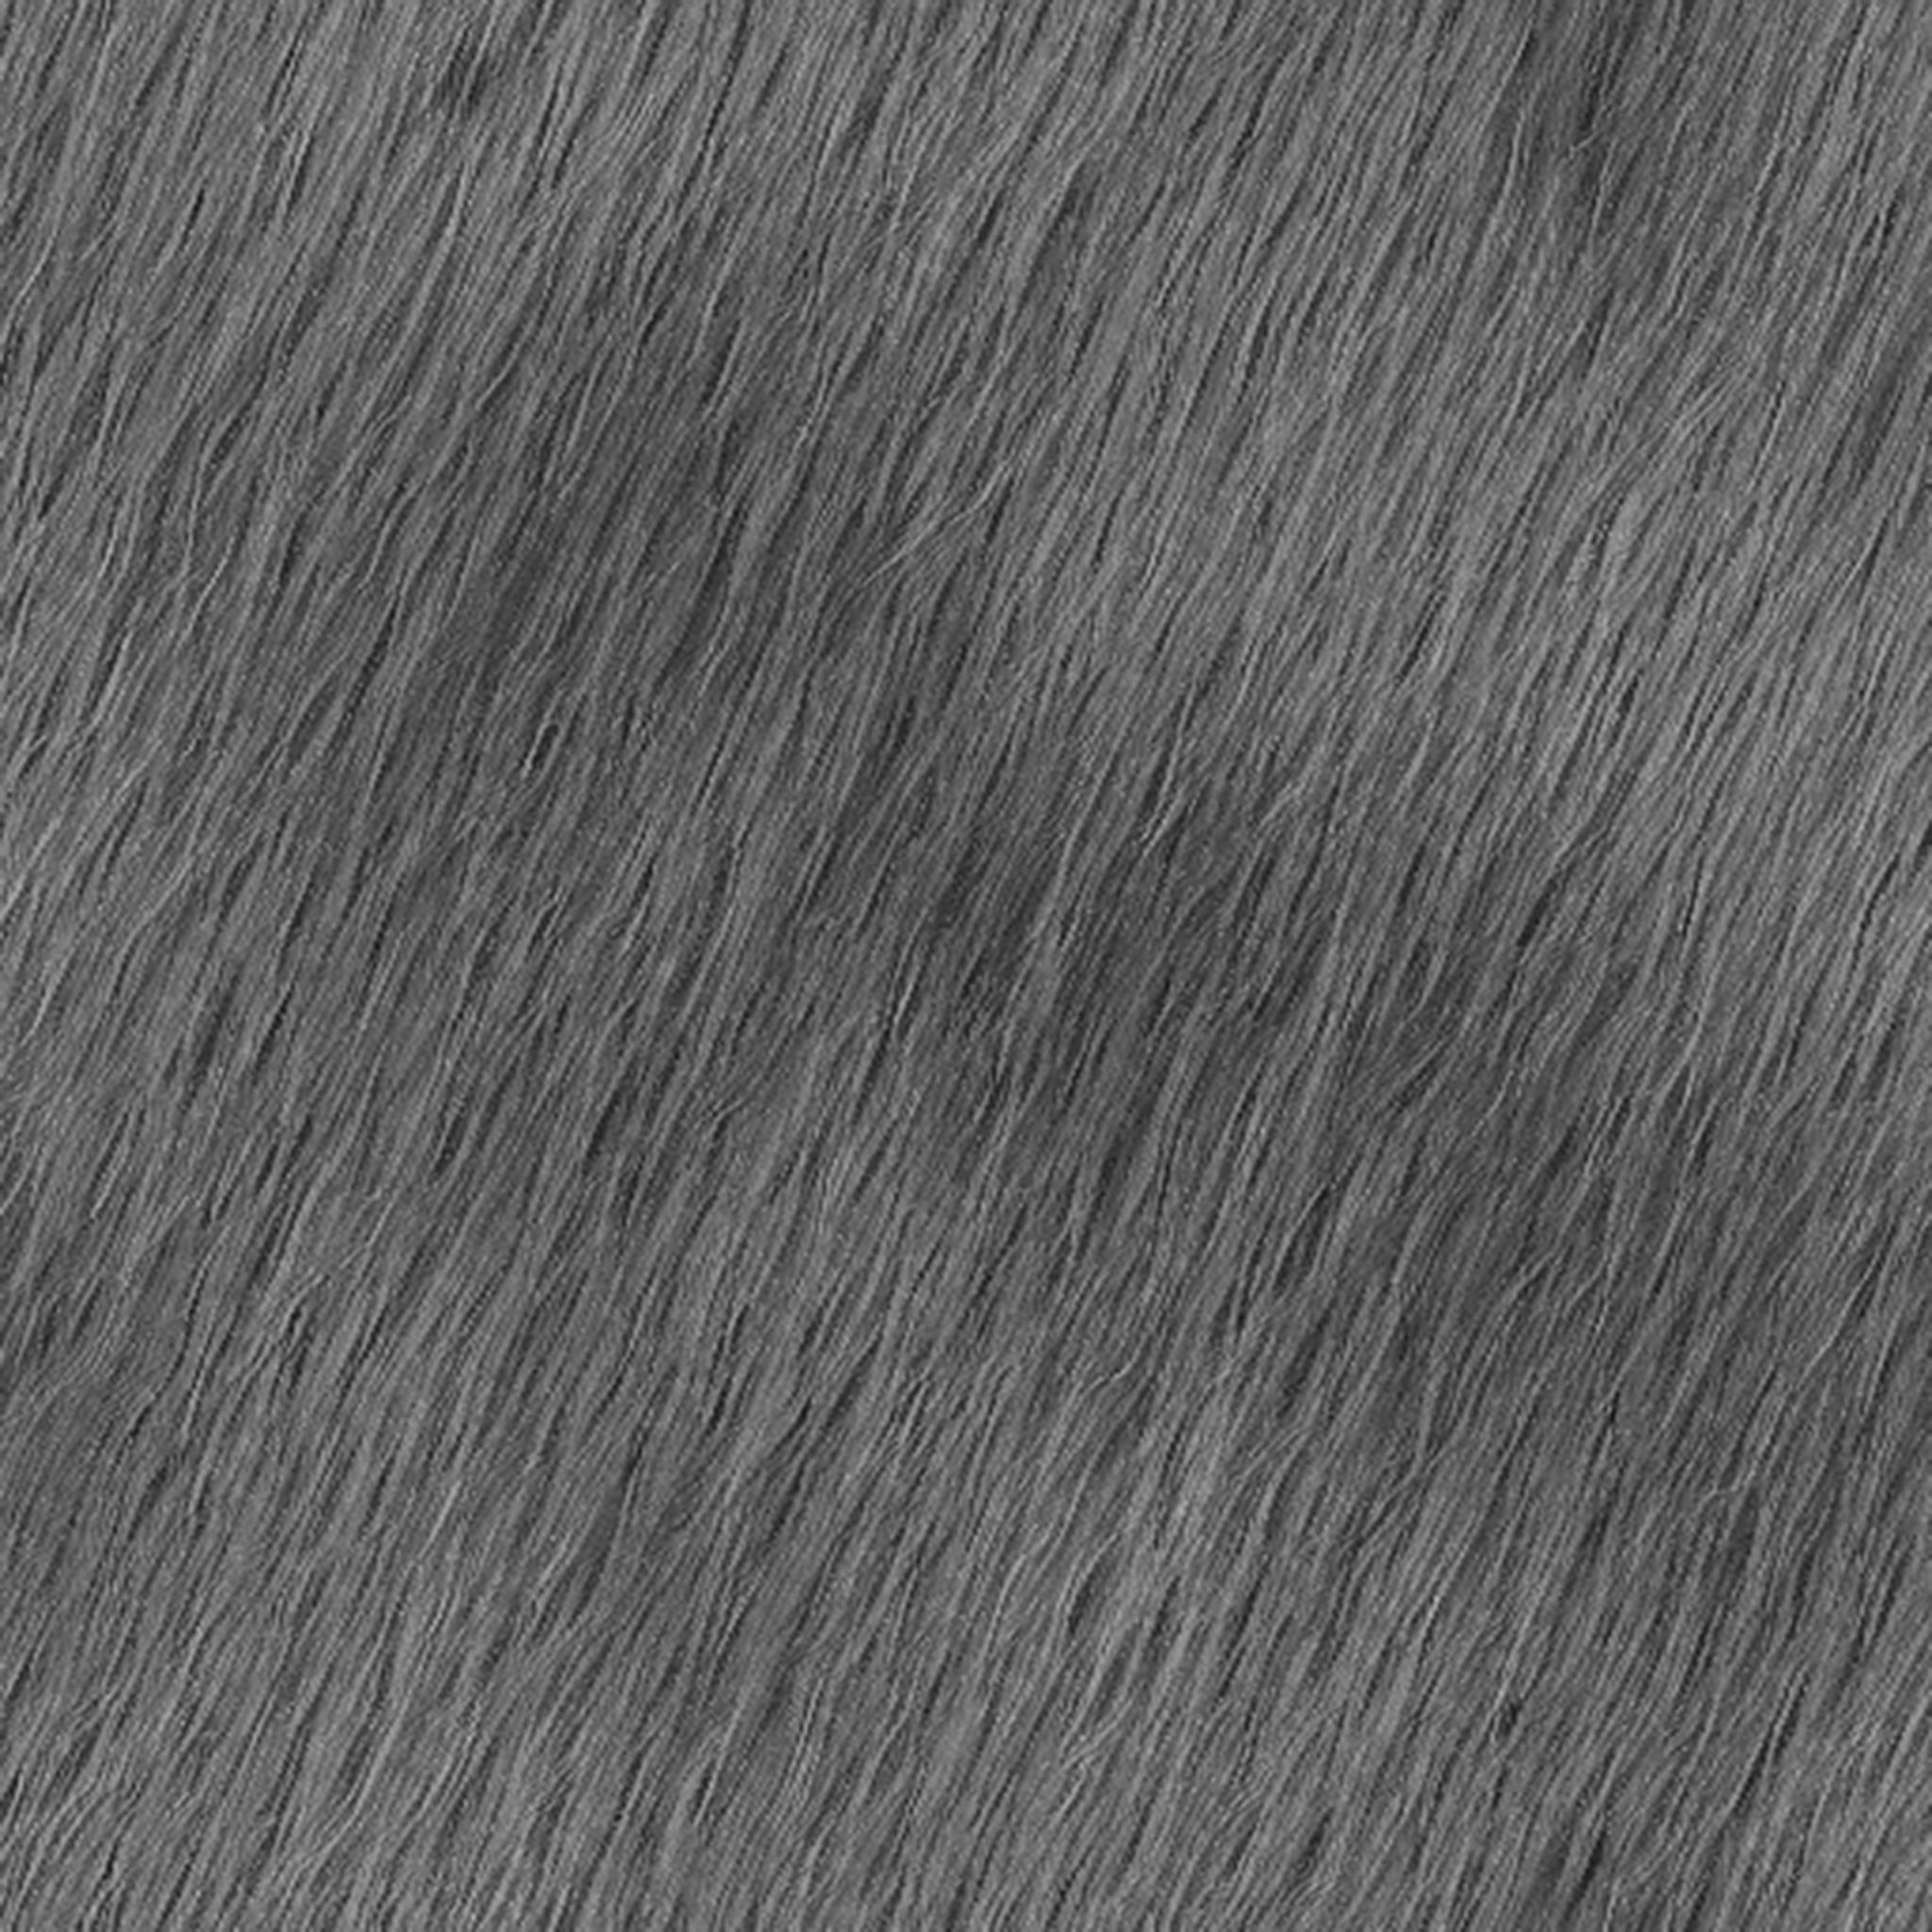

7.jpg


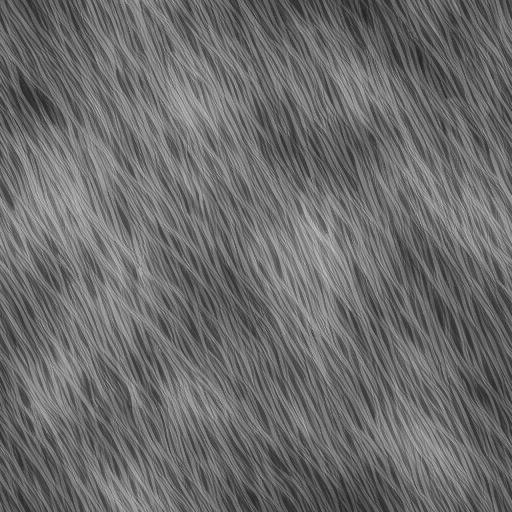

11.jpg


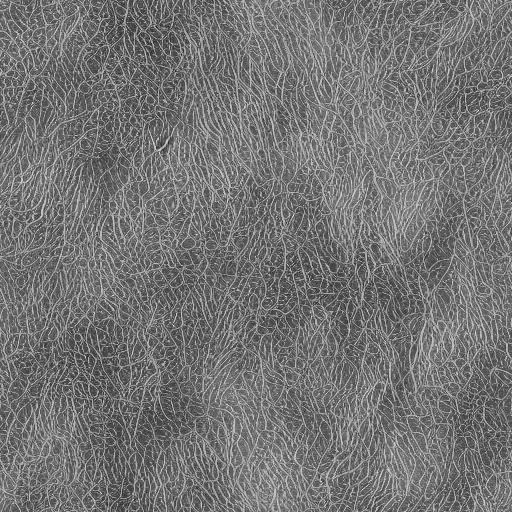

4.jpg


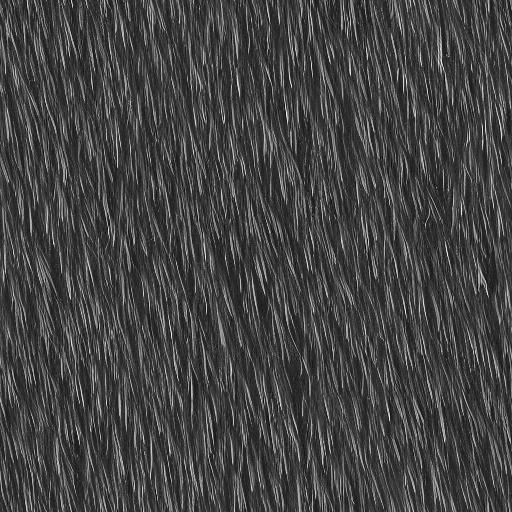

2.jpg


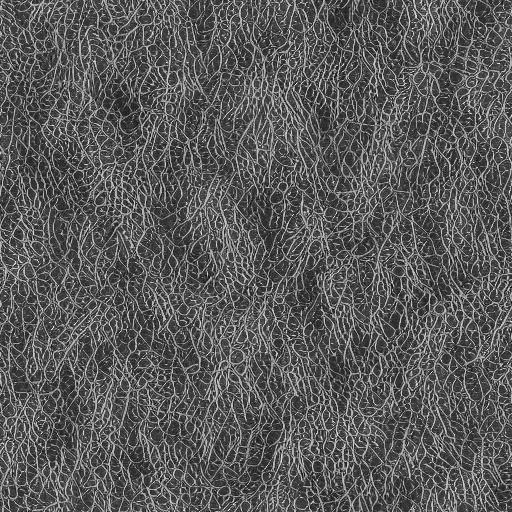

[14.08751  14.542966 16.046225 17.319742]
[13.144558 14.08751  15.307909 17.860252]
[ 7.329614 11.44449  15.307909 16.046225]
[22.87729  23.928476 24.312626 24.329666]
[18.20208  19.152706 19.513906 20.710922]
[11.44449  11.957521 17.319742 18.559404]
[19.902067 22.012207 22.136162 22.571163]
[18.494072 19.902067 19.929596 20.25596 ]
[19.264397 19.84786  20.81377  20.825323]
[34.76254  34.838444 35.00827  35.07174 ]
[19.621153 21.575651 21.789759 22.019356]
[ 7.329614 11.957521 13.144558 14.542966]
[31.06272  31.239302 31.355637 31.454021]
[20.939167 22.136162 23.892693 24.002024]
[22.87729  25.083206 25.29339  25.324251]
[17.860252 18.81805  19.692705 20.692158]
[18.494072 20.3475   20.710922 20.77629 ]


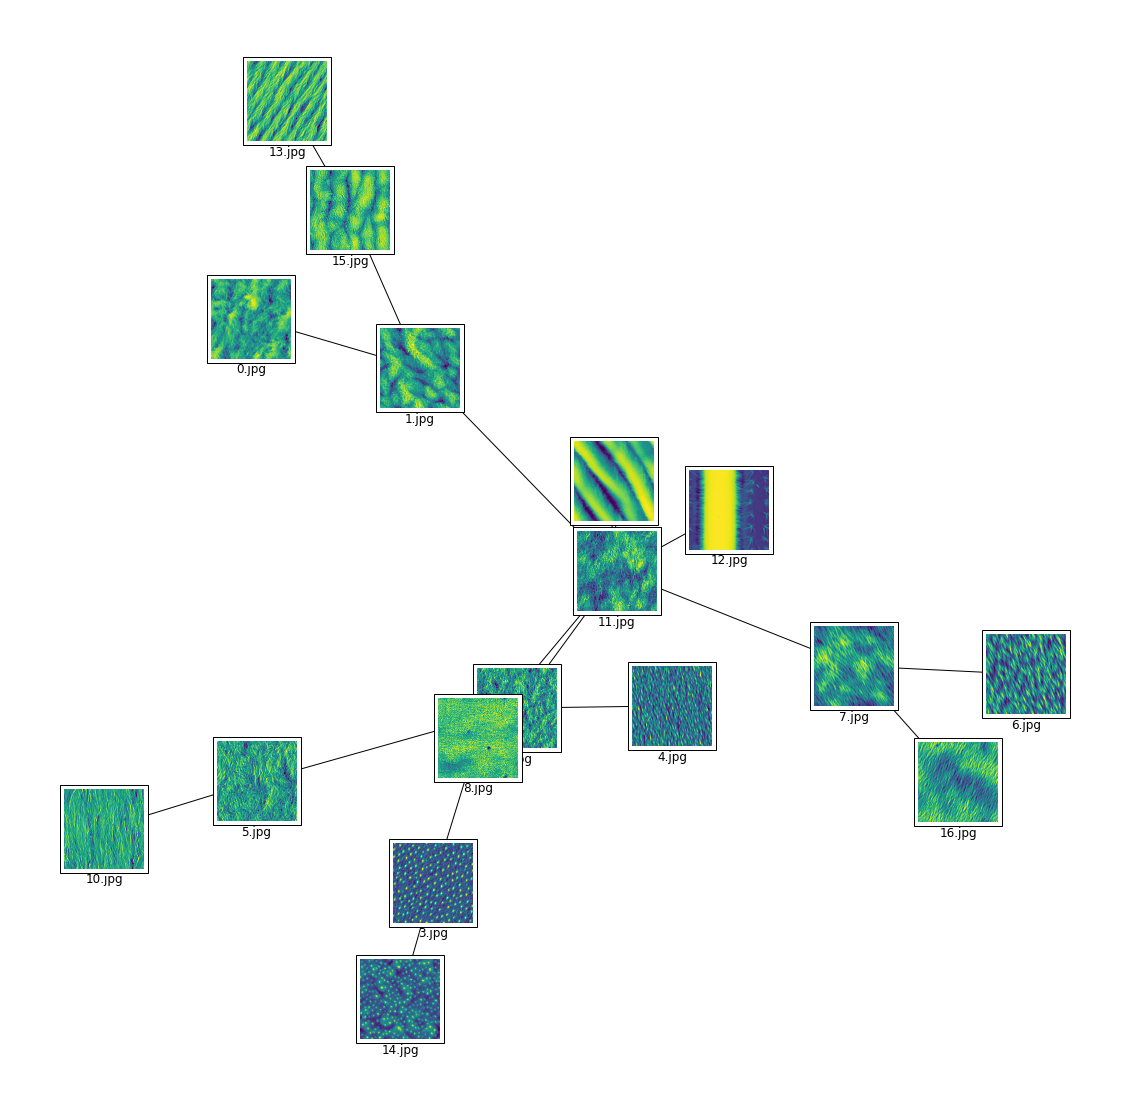

In [73]:
src_folder = f"F:/stablediffusion/cat/forget/00/4k"
dst_folder = f"F:/stablediffusion/try"
prev_nn_result_folder = f"F:/stablediffusion/PreviousNearestNeighbourResult"
process_folder(src_folder, dst_folder, prev_nn_result_folder, model)

In [ ]:
base_folder = "F:/stablediffusion/cat/reactivation"

for i in range(1,9):
    src_folder = f"{base_folder}/0{i}/4k"
    dst_folder = f"F:/stablediffusion/try"
    process_folder(src_folder, dst_folder, i)